Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,638,982 (196.99 MB)

 Trainable params: 51,638,982 (196.99 MB)

 Non-trainable params: 0 (0.00 B)

Found 3310 images belonging to 6 classes.
Found 1100 images belonging to 6 classes.
Epoch 1/20


C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.2238 - loss: 2.0157 - val_accuracy: 0.3860 - val_loss: 1.5260
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3438 - loss: 1.6040 - val_accuracy: 0.4167 - val_loss: 1.6513
Epoch 3/20


C:\Users\ADMIN\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


103/103 ━━━━━━━━━━━━━━━━━━━━ 99s 946ms/step - accuracy: 0.4259 - loss: 1.4580 - val_accuracy: 0.4127 - val_loss: 1.4579
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.4375 - loss: 1.3191 - val_accuracy: 0.6667 - val_loss: 1.0517
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 96s 911ms/step - accuracy: 0.5025 - loss: 1.3181 - val_accuracy: 0.5083 - val_loss: 1.2840
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.5000 - loss: 1.3847 - val_accuracy: 0.5833 - val_loss: 1.0805
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 95s 908ms/step - accuracy: 0.5274 - loss: 1.2123 - val_accuracy: 0.5414 - val_loss: 1.2534
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.5312 - loss: 1.1460 - val_accuracy: 0.6667 - val_loss: 0.8851
Epoch 9/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 96s 913ms/step - accuracy: 0.5615 - loss: 1.1671 - val_accuracy: 0.5368 - val_loss: 1.2550
Epoch 10/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.5000 - loss: 1.2528 - val_ac

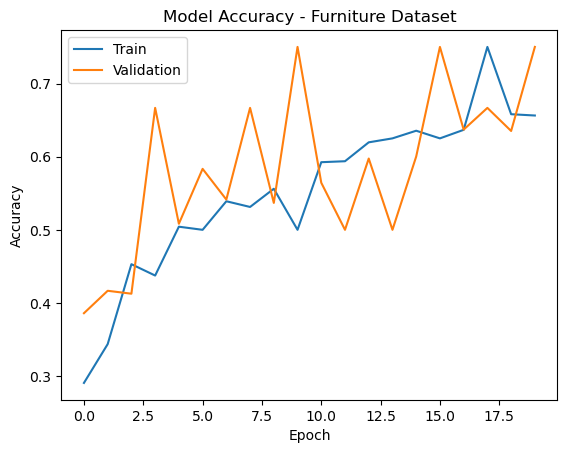

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import os
import random
import shutil
import glob
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Step 1: Define a Custom CNN Model Architecture
def build_custom_model(input_shape=(224, 224, 3), num_classes=6):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation
    return model

model = build_custom_model()
model.summary()

# Step 2: Prepare the Data
data_dir = 'test'
train_test_ratio = 0.8

def split_dataset_into_test_and_train_sets(all_data_dir=data_dir, train_test_ratio=0.8):
    if not os.path.exists('train'):
        os.makedirs('train')
    if not os.path.exists('test'):
        os.makedirs('test')

    for type_dir in os.listdir(all_data_dir):
        type_path = os.path.join(all_data_dir, type_dir)
        if os.path.isdir(type_path):
            for style_dir in os.listdir(type_path):
                style_path = os.path.join(type_path, style_dir)
                if os.path.isdir(style_path):
                    train_style_dir = os.path.join('train', type_dir, style_dir)
                    test_style_dir = os.path.join('test', type_dir, style_dir)
                    os.makedirs(train_style_dir, exist_ok=True)
                    os.makedirs(test_style_dir, exist_ok=True)

                    file_list = glob.glob(os.path.join(style_path, '*.jpg'))
                    random_set = np.random.permutation(file_list)
                    train_list = random_set[:int(len(random_set) * train_test_ratio)]
                    test_list = random_set[int(len(random_set) * train_test_ratio):]

                    for file_path in train_list:
                        if os.path.abspath(file_path) != os.path.abspath(os.path.join(train_style_dir, os.path.basename(file_path))):
                            shutil.copy(file_path, train_style_dir)
                    for file_path in test_list:
                        if os.path.abspath(file_path) != os.path.abspath(os.path.join(test_style_dir, os.path.basename(file_path))):
                            shutil.copy(file_path, test_style_dir)

split_dataset_into_test_and_train_sets()

image_size = 224
batch_size = 32

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.25
)

train_generator = train_data_gen.flow_from_directory(
    'train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = train_data_gen.flow_from_directory(
    'train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Step 3: Train the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // batch_size,
    epochs=20
)

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy - Furniture Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Step 4: Extract Features Using the Trained Model
def extract_features_custom(img_path, model, input_size=(224, 224)):
    img = image.load_img(img_path, target_size=input_size)
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(expanded_img_array)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features

def extract_features_from_dataset(directory, model, cache_path='features_cache_task2.pkl'):
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            image_paths, features_list = pickle.load(f)
    else:
        image_paths = []
        features_list = []
        for subdir, dirs, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(('jpg', 'jpeg', 'png')):
                    img_path = os.path.join(subdir, file)
                    features = extract_features_custom(img_path, model)
                    image_paths.append(img_path)
                    features_list.append(features)
        with open(cache_path, 'wb') as f:
            pickle.dump((image_paths, features_list), f)
    return image_paths, features_list

image_paths, features_list = extract_features_from_dataset('test', model)

# Step 5: Implement the Similarity Search
def recommend_similar_images(features, all_features, all_paths, n=10):
    neighbors = NearestNeighbors(metric='euclidean')
    neighbors.fit(all_features)
    distances, indices = neighbors.kneighbors([features], n_neighbors=n)
    return [all_paths[idx] for idx in indices.flatten()]

def display_images(image_paths):
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths):
        img = plt.imread(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_path))
    plt.show()

input_image_path = 'test-pic.jpg'
input_features = extract_features_custom(input_image_path, model)
recommended_images = recommend_similar_images(input_features, features_list, image_paths)

print("Recommended images:")
display_images(recommended_images)
